# Colocation of manufacturing and R&D

In [249]:
import requests
import pandas as pd

def to_dataset(url: str):
  response = requests.get(url)
  data = response.json()

  # レコード部分を抽出
  records = data["result"]["records"]

  # pandas DataFrame へ変換
  df = pd.DataFrame(records)

  # 数値列を float に変換（JSONからは文字列で来ることが多い）
  for col in df.columns:
      if col not in ["_id", "DataSeries"]:
          df[col] = pd.to_numeric(df[col], errors="coerce")

  # DataSeries を index にすると見やすい
  df.set_index("DataSeries", inplace=True)
  df.drop(columns="_id", inplace=True)

  return df

## R&D

In [250]:
import pandas as pd
import requests

# Research And Development Expenditure By Major Industry In The Private Sector, Annual          
dataset_id = "d_7b026d4bb6eb4ef783fb7521d20fc638"
url = "https://data.gov.sg/api/action/datastore_search?resource_id="  + dataset_id
        
research_development_df = to_dataset(url)

r_d_manufacturing = research_development_df.iloc[1, :]
r_d_manufacturing


2002    1326.04
2003    1373.14
2004    1598.42
2005    1949.24
2006    2189.36
2007    2949.04
2008    3726.22
2009    2029.18
2010    2089.18
2011    2004.86
2012    2432.45
2013    2373.49
2014    2615.73
2015    2946.12
2016    2753.92
2017    2749.74
2018    2335.44
2019    2989.07
2020    3366.28
2021    3690.51
2022    3673.71
Name:     Manufacturing, dtype: float64

  Biomedical & Related Sciences


<Axes: xlabel='Data Series'>

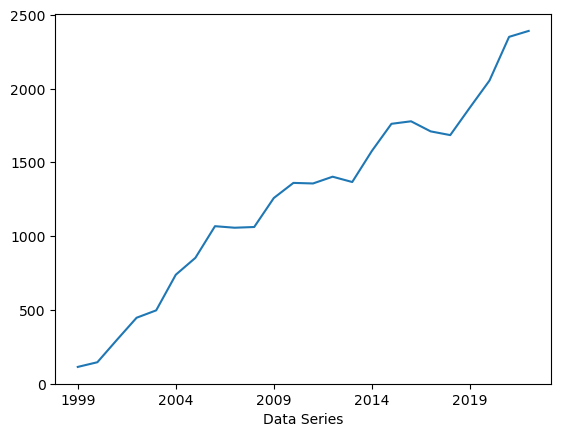

In [1]:
# Research And Development Expenditure By Institutional Sector And Area Of Research, Annual
import pandas as pd
import matplotlib.pyplot as plt


r_and_d_df = pd.read_csv("./data/singapore/sg_r_and_d_by_area.csv", header=9, index_col=0, nrows=23)

r_and_d_df.columns = r_and_d_df.loc["Data Series"].astype(int).astype(str)
r_and_d_df = r_and_d_df.drop(["Data Series"])

r_and_d_bio = r_and_d_df.iloc[3, :]
print(r_and_d_bio.name)
r_and_d_bio.sort_index(inplace=True)
r_and_d_bio.plot()



## Investment commitment

In [252]:
# Investment Commitments In Manufacturing And Services (Fixed Assets Investments) By Industry, Annual
dataset_id = "d_20e8222d6f294ad1281d7366785ca084"
url = "https://data.gov.sg/api/action/datastore_search?resource_id="  + dataset_id 
        

investment_commitment_df = to_dataset(url)
investment_manufacturing = investment_commitment_df.iloc[1, :]
investment_manufacturing

2010    10033.6
2011    11274.3
2012    14299.4
2013     7956.8
2014     6762.4
2015     8299.7
2016     5876.3
2017     6200.6
2018     5304.4
2019    10884.2
2020    13060.1
2021     8485.7
2022    17371.6
2023     8701.4
2024    11083.2
Name:     Manufacturing, dtype: float64

## FDI

In [253]:
# Foreign Direct Investment In Singapore By Detailed Industry (Stock As At Year-End), Annual
     
dataset_id = "d_36bfb288c5cf7a3ac830609d331beebd"
url = "https://data.gov.sg/api/action/datastore_search?resource_id="  + dataset_id 

fdi_df = to_dataset(url)
fdi_manufacturing = fdi_df.iloc[1, :]
fdi_manufacturing

1998     51930.9
1999     58139.6
2000     69077.6
2001     81186.2
2002     84050.6
2003     90021.1
2004     95234.9
2005    103666.0
2006    107756.1
2007    116483.2
2008    105322.8
2009    121667.3
2010    132791.9
2011    140037.6
2012    127709.5
2013    159819.5
2014    156995.7
2015    166560.9
2016    170047.6
2017    181958.2
2018    235930.0
2019    234943.7
2020    247733.2
2021    278661.1
2022    309240.2
2023    279941.3
Name:     Manufacturing, dtype: float64

## Output

Pharmaceutical & Biological Products


<Axes: xlabel='Data Series'>

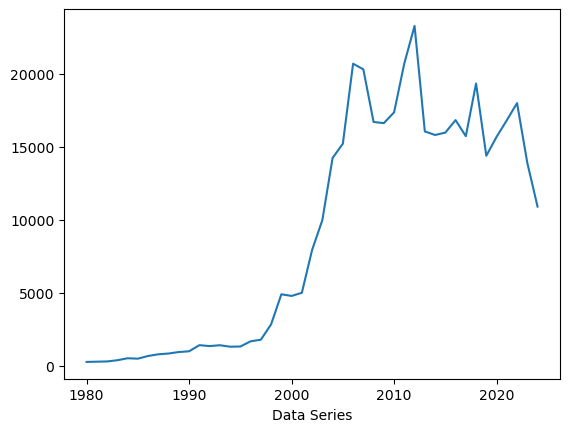

In [2]:
import pandas as pd

output_df = pd.read_csv("./data/singapore/sg_manufac_output_by_industry.csv", header=9, index_col=0, nrows=23)
output_df.columns = output_df.loc["Data Series"].astype(int).astype(str)
output_df.drop(["Data Series"], inplace=True)


output_df.index = [i.strip() for i in output_df.index]

output_medical = output_df.loc["Pharmaceutical & Biological Products"]
output_medical.sort_index(inplace=True)
print(output_medical.name)

output_manufacturing = output_df.loc["Total Manufacturing"]
output_manufacturing.sort_index(inplace=True)

output_medical.plot()
# output_manufacturing.plot()

## Relation

### R&D and fdi

0.6971877586524277


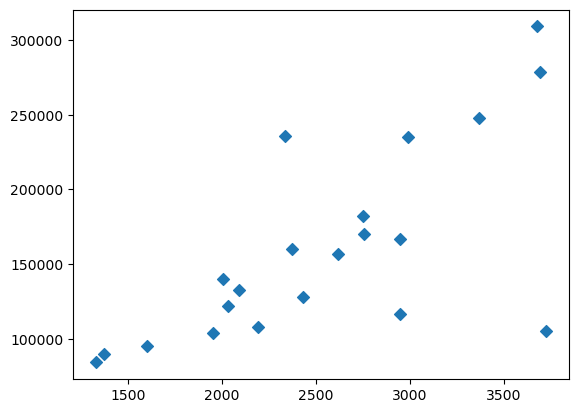

In [255]:
import matplotlib.pyplot as plt
fdi = fdi_manufacturing.loc["2002":"2022"]
r_d = r_d_manufacturing

correlation = r_d.corr(fdi)
print(correlation)

plt.scatter(r_d, fdi, marker="D")
plt.show()

### R&D and investment commitment

0.3369149552032901


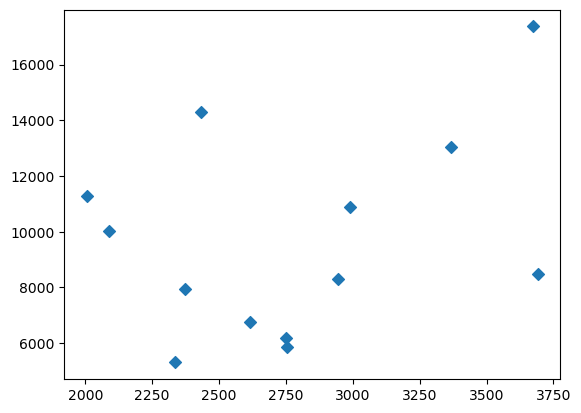

In [256]:
import matplotlib.pyplot as plt
invest = investment_manufacturing.loc[:"2022"]
r_d = r_d_manufacturing.loc["2010": ]

correlation = r_d.corr(invest)
print(correlation)

plt.scatter(r_d, invest, marker="D")
plt.show()

### R&D and output

0.7638298350454439


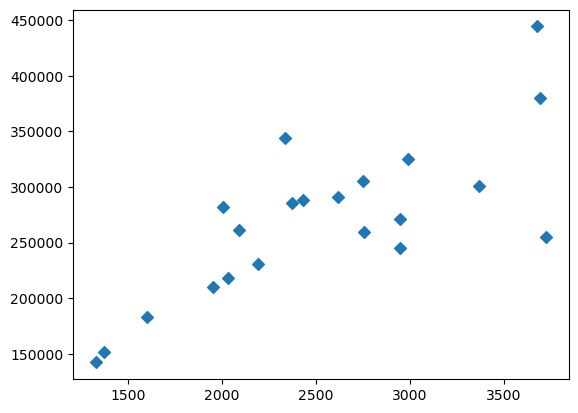

In [257]:
import matplotlib.pyplot as plt
output = output_manufacturing.loc["2002": "2022"]
r_d = r_d_manufacturing

# print(output.size, r_d.size)


correlation = r_d.corr(output)
print(correlation)

plt.scatter(r_d, output, marker="D")
plt.show()

## single regression

### stationality of r and d

In [258]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
import matplotlib.pyplot as plt


r_d_log = np.log(r_d_manufacturing)
r_d_diff = r_d_log.diff().dropna()

result = adfuller(r_d_diff)
print(f"p-value: {result[1]}")

# 時間軸を追加
t = np.arange(len(r_d_log))
X = sm.add_constant(t)

# 線形トレンドを回帰
model = sm.OLS(r_d_log, X).fit()

# トレンド成分を引く
r_d_detrended = r_d_log - model.fittedvalues

# 再度ADF検定
result = adfuller(r_d_detrended)
print(f"p-value (after detrending): {result[1]}")


r_d_boxcox, lam = boxcox(r_d_manufacturing)
r_d_diff = np.diff(r_d_boxcox)

result = adfuller(r_d_diff)
print(f"p-value (after Box–Cox + diff): {result[1]}")

p-value: 0.9955456340677591
p-value (after detrending): 0.7456773190326068
p-value (after Box–Cox + diff): 0.9940877046065353


### biomedical industry: R&D and output

In [259]:
# VAR model
# https://www.dskomei.com/entry/2020/10/13/073126
# https://www.salesanalytics.co.jp/datascience/datascience174/#i-11

In [260]:
print("R&D", r_and_d_bio.index[0], r_and_d_bio.index[-1])
print("Output", output_medical.index[0], output_medical.index[-1])

R&D 1999 2022
Output 1980 2024


0.0
2.640519691839367e-10


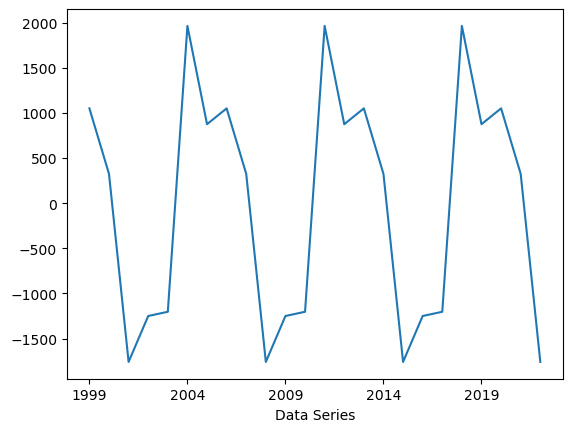

In [261]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
import matplotlib.pyplot as plt

  

r_and_d_bio_diff = r_and_d_bio.diff(8).dropna()

min_value = r_and_d_bio_diff.min()
if min_value <= 0:
  r_and_d_bio_diff = r_and_d_bio_diff - min_value + 1

r_and_d_bio_boxcox, _ = boxcox(r_and_d_bio_diff)

output_medical = output_medical["1999":"2022"]
output_medical_diff = output_medical.diff(7).dropna()

seasonal_decompose(output_medical, period=7).seasonal.plot()

min_value = output_medical_diff.min()
if min_value <= 0:
  output_medical_diff = output_medical_diff - min_value + 1

output_medical_boxcox, _ = boxcox(output_medical_diff)


print(adfuller(r_and_d_bio_boxcox)[1])
print(adfuller(output_medical_boxcox)[1])

In [262]:
print(r_and_d_bio_diff.index)
print(output_medical_diff.index)

Index(['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype='object', name='Data Series')
Index(['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype='object', name='Data Series')


In [268]:
# Series化してインデックスを保持している場合
r_and_d_bio_boxcox_series = pd.Series(r_and_d_bio_boxcox, index=r_and_d_bio_diff.index)
output_medical_boxcox_series = pd.Series(output_medical_boxcox, index=output_medical_diff.index)

# 共通期間だけを抽出
common_index = r_and_d_bio_boxcox_series.index.intersection(output_medical_boxcox_series.index)

data_for_var = pd.DataFrame({
    'r_and_d_bio': r_and_d_bio_boxcox_series.loc[common_index],
    'output_medical': output_medical_boxcox_series.loc[common_index]
})

print(data_for_var.shape)
print(data_for_var.head())


(16, 2)
             r_and_d_bio  output_medical
Data Series                             
2007         5981.501970      599.745730
2008         5759.765975      543.296740
2009         6126.744664      495.589820
2010         5738.892555      473.799928
2011         5298.853838      458.394919


In [269]:
from statsmodels.tsa.api import VAR

model = VAR(data_for_var)
lag_order_results = model.select_order(maxlags=2)
print(lag_order_results.summary())

model_fitted = model.fit(2)
print(model_fitted.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       24.02       24.12   2.717e+10       24.02
1       23.36       23.64   1.420e+10       23.34
2      22.90*      23.36*  9.442e+09*      22.86*
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Oct, 2025
Time:                     17:19:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    23.3590
Nobs:                     14.0000    HQIC:                   22.8603
Log likelihood:          -190.048    FPE:                9.44186e+09
AIC:                      22.9026    Det(Omega_mle):     5.12633e+09
--------------------------------------------------------------------
Results for equation r_and_d_bio
                       coeff

/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [272]:
granger_result = model_fitted.test_causality('r_and_d_bio', ['output_medical'], kind='f')
print(granger_result.summary())
print()
granger_result = model_fitted.test_causality('output_medical', ['r_and_d_bio'], kind='f')
print(granger_result.summary())

Granger causality F-test. H_0: output_medical does not Granger-cause r_and_d_bio. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.4628          3.555   0.637 (2, 18)
---------------------------------------------

Granger causality F-test. H_0: r_and_d_bio does not Granger-cause output_medical. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         13.59          3.555   0.000 (2, 18)
---------------------------------------------


0.6744580461564834


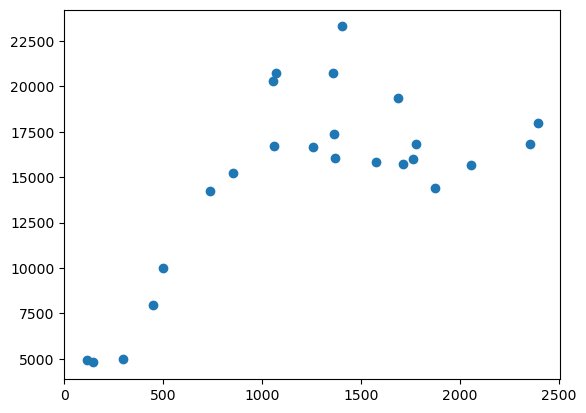

In [265]:
import matplotlib.pyplot as plt

print(r_and_d_bio.corr(output_medical))

plt.scatter(r_and_d_bio, output_medical)

plt.show()